In [56]:
import pandas as pd
import datetime
from re import sub
from decimal import Decimal

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

from langdetect import detect

from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

import boto3
from boto3 import session
from sagemaker import get_execution_role 

import seaborn as sns
import matplotlib as plt

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [57]:
# import sys
# !{sys.executable} -m pip install seaborn

In [35]:
role = get_execution_role() 

bucket = 'data-for-tests-with-sagemaker' 

data_key_listings = 'sagemaker/airbnb_data/listings.csv' 
data_listings_loc = 's3://{}/{}'.format(bucket, data_key_listings) 

data_key_reviews = 'sagemaker/airbnb_data/reviews.csv' 
data_reviews_loc = 's3://{}/{}'.format(bucket, data_key_reviews) 

df_listings = pd.read_csv(data_listings_loc)
df_reviews = pd.read_csv(data_reviews_loc)

# Importing Data 

In [8]:
# df_listings = pd.read_csv("../../data/new-york-city-airbnb-open-data/listings.csv")
# df_neighborhoods = pd.read_csv("../../data/new-york-city-airbnb-open-data/neighbourhoods.csv")
# df_reviews = pd.read_csv("../../data/new-york-city-airbnb-open-data/reviews.csv")
# df_calendar = pd.read_csv("../../data/new-york-city-airbnb-open-data/calendar.csv")
# df_listings.rename(columns = {'id':'listing_id'}, inplace = True) 

# Exploring Listings Dataframe

In [ ]:
# df_listings.shape
# list(df_listings.columns)
# df_listings.describe()
# df_listings.dtypes
# df_listings.head()
# list(df_listings.columns)
df_listings.last_scraped.value_counts()
# df_listings.host_response_time

## Dropping columns with majority NaN values

In [10]:
percent_missing = df_listings.isna().sum() * 100 / len(df_listings)
missing_value_df = pd.DataFrame({'column_name': df_listings.columns,
                                 'percent_missing': percent_missing.astype('int64')}).reset_index()

In [11]:
# exploring missing values percentage 
# missing_value_df.iloc[21:40,:]
missing_value_df['percent_missing'].value_counts()

0      72
22      7
20      4
99      3
34      3
100     3
40      2
27      2
37      2
39      1
47      1
59      1
89      1
90      1
14      1
4       1
2       1
Name: percent_missing, dtype: int64

In [12]:
# creating a list of columns to be dropped. In this case all of those with more than 30% of missing values
columns_with_nulls_drop = list(missing_value_df[missing_value_df['percent_missing']>50]['column_name'])

In [13]:
columns_with_nulls_drop

['notes',
 'thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'license',
 'jurisdiction_names']

In [14]:
# dropping columns with X% of missing values 
df_listings.drop(columns_with_nulls_drop, axis=1, inplace=True)

## Encoding binary values

In [15]:
# Encoding true and false values
df_listings.replace({'f': 0, 't': 1}, inplace=True)

In [ ]:
# df_listings.head()

## Transform dates to datetime

In [16]:
df_listings.loc[:,['last_scraped','host_since',
                 'calendar_last_scraped','first_review','last_review']] = df_listings.loc[:,['last_scraped','host_since',
                 'calendar_last_scraped','first_review','last_review']].apply(pd.to_datetime, errors='coerce')

In [17]:
# df_listings.iloc[0:20,:].dtypes
df_listings.listing_url.head()

0    https://www.airbnb.com/rooms/2060
1    https://www.airbnb.com/rooms/2595
2    https://www.airbnb.com/rooms/3831
3    https://www.airbnb.com/rooms/5099
4    https://www.airbnb.com/rooms/5114
Name: listing_url, dtype: object

In [ ]:
# df_listings.dtypes

## Separating columns for NLP

In [18]:
df_listings_for_NLP = df_listings.select_dtypes(include=['object'])
df_listings_non_text = df_listings.select_dtypes(exclude=['object'])

## Working with numerical data

host_listings_count and host_total_listings_count are always the same except in 5 cases where they are NaN. Therefore
those columns will be dropped

In [19]:
print(sum((df_listings_non_text['host_listings_count'] 
           == df_listings_non_text['host_total_listings_count']) 
          == False))

df_listings_non_text.loc[((df_listings_non_text.host_listings_count 
                           == df_listings_non_text.host_total_listings_count) 
                          == False)]

5


,id,scrape_id,last_scraped,host_id,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
5436,4446862,20200313233810,2020-03-14,23077718,NaT,NaN,NaN,NaN,NaN,NaN,40.67512,-73.96146,1,2,1.0,1.0,1.0,1,1,1125,1,1,1125,1125,1.0,1125.0,1,0,0,0,0,2020-03-14,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,NaN
5892,4763327,20200313233810,2020-03-14,24576978,NaT,NaN,NaN,NaN,NaN,NaN,40.72035,-73.95355,1,4,1.0,1.0,2.0,2,1,1125,1,1,1125,1125,1.0,1125.0,1,0,0,0,0,2020-03-14,1,0,2015-10-20,2015-10-20,80.0,8.0,10.0,10.0,8.0,10.0,8.0,0,0,0,0,0,1,1,0,0,0.02
7404,6360224,20200313233810,2020-03-14,33134899,NaT,NaN,NaN,NaN,NaN,NaN,40.70146,-73.92792,1,1,0.0,1.0,1.0,1,1,1125,1,1,1125,1125,1.0,1125.0,1,0,0,0,0,2020-03-14,1,0,2015-07-01,2015-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,0.02
8190,6992973,20200313233810,2020-03-14,5162530,NaT,NaN,NaN,NaN,NaN,NaN,40.71838,-73.95630,1,4,2.0,2.0,1.0,2,1,1125,1,1,1125,1125,1.0,1125.0,1,0,0,0,0,2020-03-14,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,1,0,0,NaN
8795,7556587,20200313233810,2020-03-14,39608626,NaT,NaN,NaN,NaN,NaN,NaN,40.82929,-73.94182,1,2,1.0,1.0,1.0,1,1,1125,1,1,1125,1125,1.0,1125.0,1,0,0,0,0,2020-03-14,1,0,2015-08-01,2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,0.02


In [20]:
df_listings_non_text.drop(['host_listings_count','host_total_listings_count'], axis=1, inplace=True)

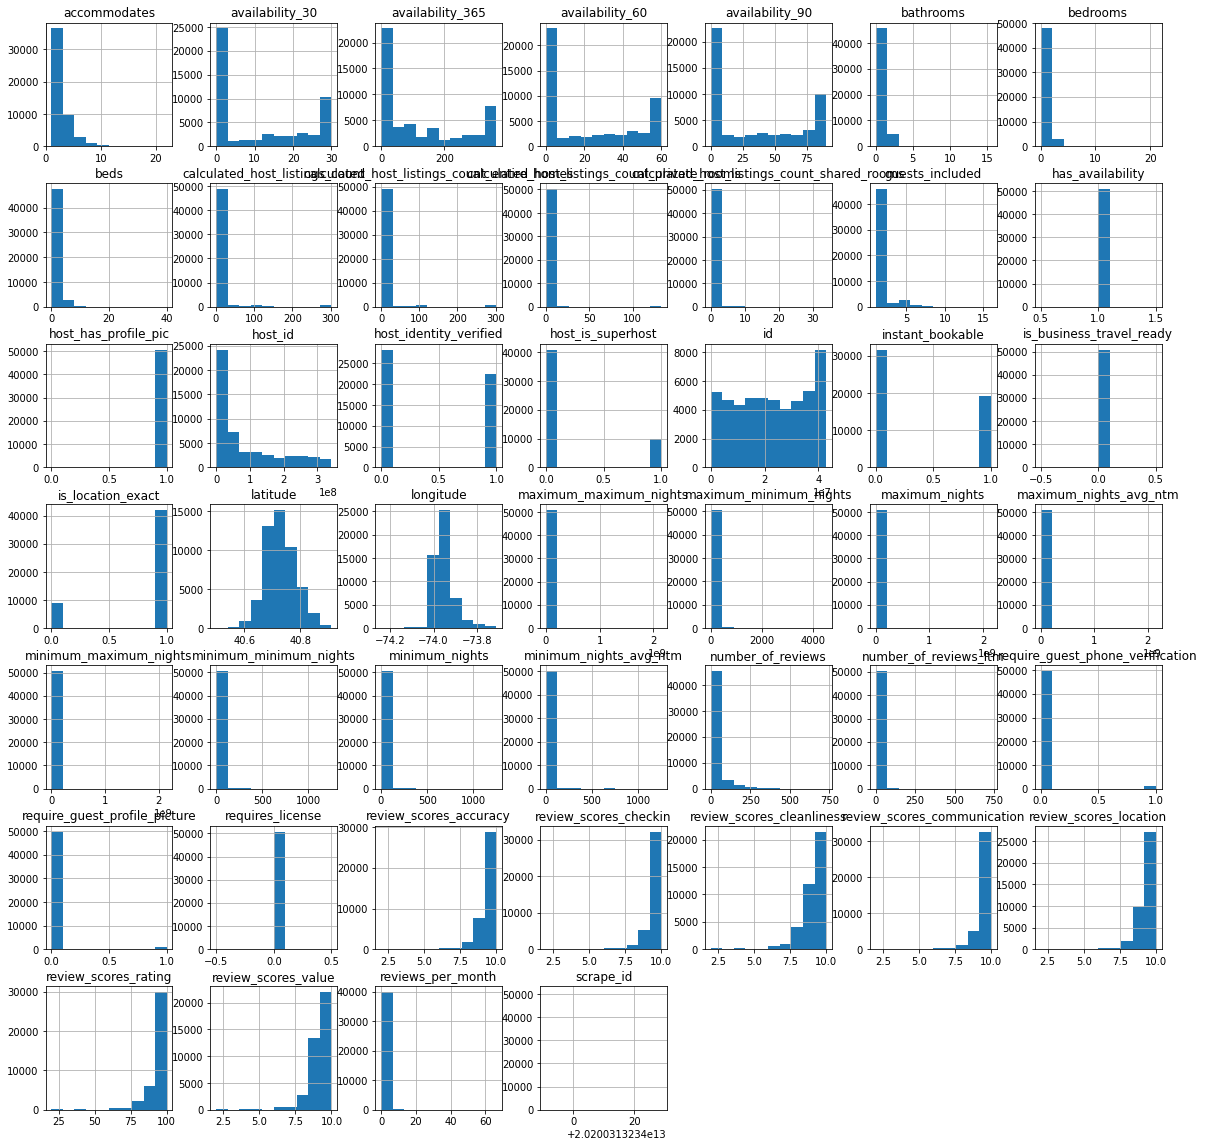

In [21]:
# Plotting the distribution of numerical and boolean categories
df_listings_non_text.hist(figsize=(20,20));

In [22]:
# drop columns with a single category
df_listings_non_text.drop(['has_availability', 'host_has_profile_pic', 
                      'is_business_travel_ready', 'require_guest_phone_verification', 
                      'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

## Cleaning individual columns

**host_since**

In [31]:
# df_listings_non_text.host_since.value_counts()
df_listings_non_text.host_since.head()

# Calculating the number of days a host has been active to scraping date
df_listings_non_text['host_days_active'] = df_listings_non_text.loc[:,'host_since'].apply(lambda x: 
                                                                                          datetime.datetime(
                                                                                              2020, 3, 14) - x)

# Printing mean and median
print("Mean days as host:", df_listings_non_text['host_days_active'].mean().days)
print("Median days as host:", df_listings_non_text['host_days_active'].median().days)

# Replacing null values with the median
pd.Timedelta(days=median_days)

Mean days as host: 1669
Median days as host: 1698


Timedelta('1698 days 00:00:00')

***

# NLP Analysis

## Sentiment Analysis of review comments

In [36]:
# df_reviews.shape
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2060,158,2008-09-22,2865,Thom,"very nice neighborhood,close enough to ""A"" tra..."
1,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
2,2595,19176,2009-12-05,53267,Cate,Great experience.
3,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
4,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."


In [37]:
# calculates compound sentiment polarity of the sentence
vader_polarity_compound = lambda x: (SentimentIntensityAnalyzer().polarity_scores(x))['compound']

# We can retrieve scores for positive, negative or neutral sentiment. 
# We will use the compound: a normalized value: norm_score = score / math.sqrt((score * score) + alpha)
print(SentimentIntensityAnalyzer().polarity_scores('VADER is smart, handsome, and funny.'))

{'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}


In [38]:
# determining the number of no comments
"{}% of reviews have empty comments".format((df_reviews.comments.isnull().sum() / df_reviews.comments.shape[0]) *100)
# "My name is {}, I'am {}".format("John",36)

'0.05879231633876933% of reviews have empty comments'

In [39]:
# Since the percentage is so insignificant, these rows will be dropped
df_reviews.dropna(subset=['comments'], how='any', axis=0, inplace=True)

Using the pre-trained Vader sentiment model based on NLTK go create polarity scores for all reviews:

In [41]:
# df_reviews['polarity'] = df_reviews.comments.map(vader_polarity_compound)

Function that predicts the language. It needs to be passed a string with decent amount of characters, thus the calculation on the fly of the lenght of the string passed.

In [ ]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>100:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [ ]:
df_reviews['review_lang'] = df_reviews.comments.apply(lambda x: predict_lang(x))

We observe that a lot of reviews didnt get a language value. This is because their length was too short for the calculation

In [ ]:
# df_reviews.review_lang.value_counts()

Reviews were exported for both English and Spanish. I checked the spanish reviews fo sentiment and wasn't accurate what leads me to believe that this algorithm works best for English text

In [ ]:
df_reviews[df_reviews.review_lang == 'en'].to_csv('reviews_with_sentiment_en.csv', sep='\t', index=False)

## How to Relate Host Response Time with Review Score Communication?

**host_response_time**

In [97]:
df_listings_for_NLP.host_response_time.value_counts(dropna=False), df_listings_for_NLP.shape

(within an hour        20445
 NaN                   19006
 within a few hours     6009
 within a day           4218
 a few days or more     1118
 Name: host_response_time, dtype: int64,
 (50796, 44))

Understanding how many null values does this column have and what is the overall proportion to the total

In [43]:
print("Null values in host response time:", df_listings_for_NLP.host_response_time.isna().sum())
print(f"Proportion to the hosts WITHOUT response time: {round((df_listings_for_NLP.host_response_time.isna().sum()/len(df_listings_for_NLP))*100, 1)}%")

Null values in host response time: 19006
Proportion to the hosts WITHOUT response time: 37.4%


Histogram to visualize frequency

Text(0.5, 1.0, 'Count of types of response times available on AirBnb')

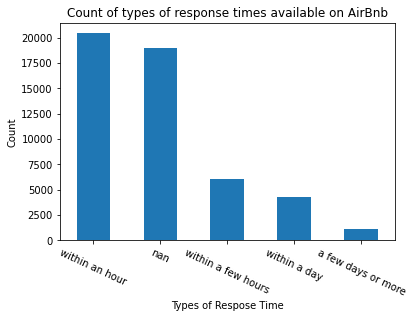

In [74]:
df_listings_for_NLP.host_response_time.value_counts(dropna=False).plot(kind='bar')    
    
plt.pyplot.xticks(rotation=-25) #Rotate xticks
plt.pyplot.xlabel('Types of Respose Time')
plt.pyplot.ylabel('Count')
plt.pyplot.title('Count of types of response times available on AirBnb')

**Is there a connection between hosts not having response time and the reviews they get in terms of communication**?

In [106]:
# Number of rows without a value for host_response_time which have also not yet had a review
df_host_response_review = pd.concat([df_listings_for_NLP['host_response_time'],
                                     df_listings_non_text['first_review']], axis=1)

cond = df_host_response_review.loc[:,['host_response_time','first_review']].isnull().sum(axis=1) == 2
host_with_no_resp_time = len(df_host_response_review[cond])
print("Hosts with no response time that don't have a review yet:", host_with_no_resp_time)

print("Proportion to total hosts with no response time:", 
     (host_with_no_resp_time/df_host_response_review.host_response_time.isna().sum())*100)

Hosts with no response time that don't have a review yet: 5608
Proportion to total hosts with no response time: 29.50647164053457


5608

In [ ]:
# df_listings_non_text.review_scores_communication.value_counts()
# df_listings_non_text.review_scores_communication.isna().sum()

tmp = df_listings

In [ ]:
tmp=tmp.loc[:,['host_response_time','first_review','review_scores_communication']]

In [ ]:
tmp.host_response_time.hist();

**Is there a correlation between response rate an a positive review?**

In [ ]:
# calendar_last_scraped                           datetime64[ns]
# number_of_reviews                                        int64
# number_of_reviews_ltm                                    int64
# first_review                                            object
# last_review                                     datetime64[ns]
# review_scores_rating                                   float64
# review_scores_accuracy                                 float64
# review_scores_cleanliness                              float64
# review_scores_checkin                                  float64
# review_scores_communication                            float64
# review_scores_location                                 float64
# review_scores_value                                    float64

**Is there correlation between starring and host response rate?**

In [ ]:
# Normalizing the data
df_listings_for_NLP.host_response_time.fillna("unknown", inplace=True)
df_listings_for_NLP.host_response_time.value_counts(normalize=True)

***

## Count the number of unique listings in calendar and listings DF

In [ ]:
df_calendar['listing_id'].nunique()

## Joining calendar with listings. I want to know data from what years are available

In [ ]:
# df_listings_date = pd.merge(df_listings, df_calendar, how='inner', on=['listing_id', 'listing_id'])

In [ ]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar ['year'] = pd.DatetimeIndex(df_calendar['date']).year

## Years of listings available

In [ ]:
pd.Categorical(df_calendar['year'])

## Creating season label

In [ ]:
df_calendar['season'] = (pd.DatetimeIndex(df_calendar['date']).month%12 + 3)//3
df_calendar['season_l'] = pd.cut(df_calendar['season'], 4, labels=["winter", "spring", "summer","autum"])

In [ ]:
# df_calendar[df_calendar['season']==1]
df_calendar.head()
# df_calendar.shape

## Understanding the difference between adjusted price and price

In [ ]:
# example = [sub(r'[^\d.]', '', r['price']) for i, r in df_calendar_temp.iterrows()]
df_calendar['price'] = [float(sub(r'[^\d.]', '', r['price'])) for i, r in df_calendar.iterrows()]

In [ ]:
df_calendar['adjusted_price'] = [float(sub(r'[^\d.]', '', r['adjusted_price'])) for i, r in df_calendar.iterrows()]

In [ ]:
df_calendar['difference_price_adjusted'] = df_calendar['price'] - df_calendar['adjusted_price'] 

In [ ]:
# df_calendar[df_calendar['difference_price_adjusted']<0]
# conclusion: there is a difference between adjusted price and actual price. We need to further investigate

## Which areas of have the most Airbnb properties, and which are the most expensive?

In [ ]:
df_calendar[df_calendar['difference_price_adjusted']<0]